# Question 1

#### Initialization

In [1]:
# import all relavent libraries
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load csv and preview the first 5 rows
current_working_directory = os.getcwd()
df = pd.read_csv(current_working_directory + '\\jewelry_customers.csv')
df.head()

,Age,Income,SpendingScore,Savings
0,58,77769,0.791329,6559.829923
1,59,81799,0.791082,5417.661426
2,62,74751,0.702657,9258.992965
3,59,74373,0.765680,7346.334504
4,87,17760,0.348778,16869.507130


In [3]:
# Standardize each feature and save it as X
X = df.copy()
scaler = StandardScaler()
features = list(df)
X[features] = scaler.fit_transform(X[features])
X.head()

,Age,Income,SpendingScore,Savings
0,-0.042287,0.062733,1.103593,-1.072467
1,-0.000821,0.174811,1.102641,-1.303473
2,0.123577,-0.021200,0.761727,-0.526556
3,-0.000821,-0.031712,1.004705,-0.913395
4,1.160228,-1.606165,-0.602619,1.012686


In [4]:
# Although Income/Age and Savings/SpendingScore are highly correlated feature pairs, I have decided not to remove any features unless I get really low performances
!pip install pandas_profiling
import pandas_profiling
pandas_profiling.ProfileReport(df)

#### K-Means

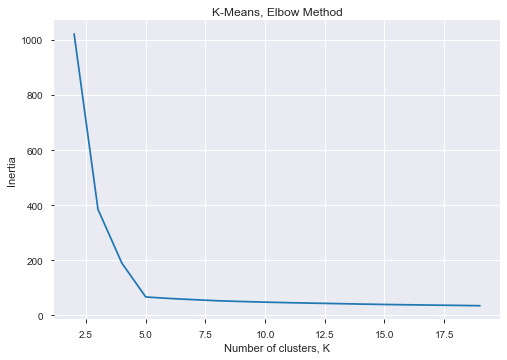

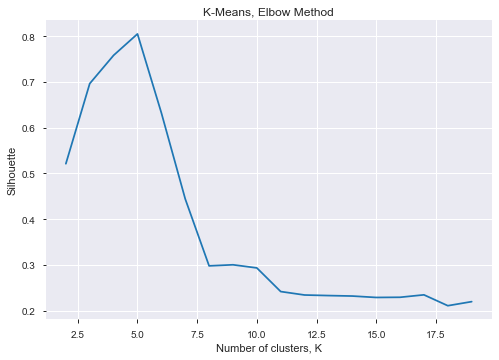

In [5]:
# trying out different K (from 2 to 20) and drawing out the elbow curves
inertias = {}
silhouettes = {}
for k in range(2, 20):
    kmeans = KMeans(init='k-means++', n_init=100, n_clusters=k, max_iter=1000, random_state=42).fit(X)
    inertias[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    silhouettes[k] = silhouette_score(X, kmeans.labels_)

plt.figure()
plt.grid(True)
plt.plot(list(inertias.keys()), list(inertias.values()))
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K")
plt.ylabel("Inertia")

plt.figure();
plt.grid(True);
plt.plot(list(silhouettes.keys()), list(silhouettes.values()))
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K")
plt.ylabel("Silhouette")

plt.show()

In [6]:
# based on the graphs above, running K-Means with K = 5 and storing cluster ID as a new column of df
kmeans = KMeans(init='k-means++', n_init=100, n_clusters=5, max_iter=1000, random_state=42).fit(X)
kmeans.fit(X)
df['K-Means Clusters'] = kmeans.labels_
df.head()

,Age,Income,SpendingScore,Savings,K-Means Clusters
0,58,77769,0.791329,6559.829923,1
1,59,81799,0.791082,5417.661426,1
2,62,74751,0.702657,9258.992965,1
3,59,74373,0.765680,7346.334504,1
4,87,17760,0.348778,16869.507130,2


#### DBSCAN

In [7]:
def DBSCAN_parameter_tuning(eps_min,eps_max,eps_incre,min_sample, max_sample):
    '''
    input: takes in a range of eps and min_samples
    output: a dataframe with the following columns: metric, min_sample, eps, n_clusters, silhouettes
    '''
    output_silhouettes = []
    output_n_clusters = []
    output_eps = []
    output_min_sample = []
    output_metric = []
    
    epss = np.arange(eps_min, eps_max + eps_incre, eps_incre)
    min_samples = np.arange(min_sample, max_sample + 1, 1)
    metrics = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
    
    for metric in metrics:
        for eps in epss:
            for min_sample in min_samples:
                db = DBSCAN(eps=eps, min_samples=min_sample,metric=metric).fit(X)
                number_of_clusters = len(set(db.labels_))
                if number_of_clusters == 1:
                    continue
                else:
                    output_silhouettes.append(silhouette_score(X, db.labels_,metric=metric))
                    output_n_clusters.append(number_of_clusters)
                    output_eps.append(eps)
                    output_min_sample.append(min_sample)
                    output_metric.append(metric)
    
    return pd.DataFrame({'metric':output_metric,'min_sample':output_min_sample,'eps':output_eps,'n_clusters':output_n_clusters,'silhouettes':output_silhouettes})

In [8]:
# eps ranged from 0.1 to 1.0 (in 0.1 steps) and min_samples ranged from 3 to 6 are experienmented
df_DBSCAN_result = DBSCAN_parameter_tuning(0.1,1,0.1,3,6)
df_DBSCAN_result.sort_values(by='silhouettes',ascending = False).head(15)

,metric,min_sample,eps,n_clusters,silhouettes
38,cosine,4,0.1,4,0.921631
37,cosine,3,0.1,4,0.921631
44,cosine,6,0.2,4,0.921631
41,cosine,3,0.2,4,0.921631
40,cosine,6,0.1,4,0.921631
39,cosine,5,0.1,4,0.921631
42,cosine,4,0.2,4,0.921631
43,cosine,5,0.2,4,0.921631
48,cosine,6,0.3,3,0.879011
47,cosine,5,0.3,3,0.879011


In [9]:
# based on the graphs above, running DBSCAN with eps = 0.2 and min_samples = 6 and metric = cosine and storing cluster ID as a new column of df
db = DBSCAN(eps=0.2, min_samples=6,metric='cosine')
db.fit(X)
df['DBSCAN Clusters'] = db.labels_
df.head()

,Age,Income,SpendingScore,Savings,K-Means Clusters,DBSCAN Clusters
0,58,77769,0.791329,6559.829923,1,0
1,59,81799,0.791082,5417.661426,1,0
2,62,74751,0.702657,9258.992965,1,0
3,59,74373,0.765680,7346.334504,1,0
4,87,17760,0.348778,16869.507130,2,1


#### Hierarchical

In [10]:
def hierarc_parameter_tuning(list_of_clusters):
    '''
    input: takes in a list of clusters interested for experienmentation
    output: a dataframe with the following columns: linkage, affinity, n_clusters, silhouettes
    '''
    output_silhouettes = []
    output_n_clusters = []
    output_linkage = []
    output_affinity = []
    
    affinitys = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
    linkages = ['ward', 'complete', 'average', 'single']
    
    for n in list_of_clusters:
        for affinity in affinitys:
            for linkage in linkages:
                if linkage == 'ward' and affinity != 'euclidean':
                    continue
                else:
                    agg = AgglomerativeClustering(n_clusters=n, affinity=affinity, linkage=linkage).fit(X)
                    output_silhouettes.append(silhouette_score(X, agg.labels_,metric=affinity))
                    output_n_clusters.append(n)
                    output_linkage.append(linkage)
                    output_affinity.append(affinity)
    return pd.DataFrame({'linkage':output_linkage,'affinity':output_affinity,'n_clusters':output_n_clusters,'silhouettes':output_silhouettes})

In [11]:
# experienmenting through clusters 2 to 10 and printing out the combinations with the highest silhouettes scores
df_hierarc_result = hierarc_parameter_tuning([2,3,4,5,6,7,8,9,10])
df_hierarc_result.sort_values(by='silhouettes',ascending = False).head(15)

,linkage,affinity,n_clusters,silhouettes
63,single,cosine,5,0.930676
62,average,cosine,5,0.930676
61,complete,cosine,5,0.930676
45,complete,cosine,4,0.921631
46,average,cosine,4,0.921631
47,single,cosine,4,0.921631
30,average,cosine,3,0.879011
31,single,cosine,3,0.879011
29,complete,cosine,3,0.879011
79,single,cosine,6,0.839994


In [12]:
# decided to use cosine and average with clusters = 5 and storing cluster ID as a new column of df
agg = AgglomerativeClustering(n_clusters=5, affinity='cosine', linkage='average').fit(X)
df['Hier Clusters'] = agg.labels_
df.head()

,Age,Income,SpendingScore,Savings,K-Means Clusters,DBSCAN Clusters,Hier Clusters
0,58,77769,0.791329,6559.829923,1,0,1
1,59,81799,0.791082,5417.661426,1,0,1
2,62,74751,0.702657,9258.992965,1,0,1
3,59,74373,0.765680,7346.334504,1,0,1
4,87,17760,0.348778,16869.507130,2,1,2


#### K-Means vs DBSCAN vs Hierarchical

In [13]:
# finding out the feature means of each K-Means cluster and display its % and print out its silhouette_score
alg = 'K-Means Clusters'
a = df.groupby(alg).count()[['Age']]/df.shape[0]
a.columns = ['%']
b = df.groupby(alg).mean()[['Age','Income','SpendingScore','Savings']]
c = b.join(a)
print(silhouette_score(X, kmeans.labels_))
c.sort_values(by='Age')

0.8048976287755765


,Age,Income,SpendingScore,Savings,%
K-Means Clusters,,,,,
3,24.180000,128029.120000,0.896892,4087.520309,0.099010
0,32.777778,105265.809524,0.309926,14962.778066,0.249505
1,59.955414,72448.063694,0.771518,6889.972190,0.310891
4,86.000000,119944.040000,0.068378,14808.683793,0.049505
2,87.775510,27866.102041,0.328800,16659.261445,0.291089


In [14]:
# finding out the feature means of each DBSCAN cluster and display its % and print out its silhouette_score
alg = 'DBSCAN Clusters'
a = df.groupby(alg).count()[['Age']]/df.shape[0]
a.columns = ['%']
b = df.groupby(alg).mean()[['Age','Income','SpendingScore','Savings']]
c = b.join(a)
print(silhouette_score(X, db.labels_,metric='cosine'))
c.sort_values(by='Age')

0.9216306703857284


,Age,Income,SpendingScore,Savings,%
DBSCAN Clusters,,,,,
3,32.777778,105265.809524,0.309926,14962.778066,0.249505
0,51.314010,85873.439614,0.801802,6213.051446,0.409901
2,86.000000,119944.040000,0.068378,14808.683793,0.049505
1,87.775510,27866.102041,0.328800,16659.261445,0.291089


In [15]:
# finding out the feature means of each Hierarchical cluster and display its % and print out its silhouette_score
alg = 'Hier Clusters'
a = df.groupby(alg).count()[['Age']]/df.shape[0]
a.columns = ['%']
b = df.groupby(alg).mean()[['Age','Income','SpendingScore','Savings']]
c = b.join(a)
print(silhouette_score(X, agg.labels_,metric='cosine'))
c.sort_values(by='Age')

0.9306761597160207


,Age,Income,SpendingScore,Savings,%
Hier Clusters,,,,,
4,24.180000,128029.120000,0.896892,4087.520309,0.099010
0,32.777778,105265.809524,0.309926,14962.778066,0.249505
1,59.955414,72448.063694,0.771518,6889.972190,0.310891
3,86.000000,119944.040000,0.068378,14808.683793,0.049505
2,87.775510,27866.102041,0.328800,16659.261445,0.291089


# Question 2

#### Manual - 1st Split

In [16]:
# the function below calculates the entropy with input x as the % of a "True" Target
def entropy(x):
    if x == 1 or x == 0:
        return 0.0
    else:
        return -x*np.log2(x)-(1-x)*np.log2(1-x)

In [17]:
# the function below returns gain based on inputs
def gain(p_true,e_true,e_false,original_gain):
    p_false = 1 - p_true
    return original_gain - (p_true * e_true + p_false * e_false)

In [18]:
# the function below prints the splited table based on column_name input
def split_table_by_column(df,column_name):
    print(df[df[column_name] == True])
    print('\n')
    print(df[df[column_name] == False])

In [19]:
# training data imported as a Pandas Dataframe
data2 = {'Good Behavior': [False, False, False, True, True, True],
         'Age < 30': [True, False, True, False, False, False],
         'Drug dependent': [False, False, False, False, True, False],
         'Recidivist': [True, False, True, False, True, False],
        }
df2 = pd.DataFrame(data=data2)
print(df2)
# entropy of entire training dataset
entropy(3/6)

   Good Behavior  Age < 30  Drug dependent  Recidivist
0          False      True           False        True
1          False     False           False       False
2          False      True           False        True
3           True     False           False       False
4           True     False            True        True
5           True     False           False       False


1.0

In [20]:
# split table by Good Behavior
split_table_by_column(df2,'Good Behavior')
gain(3/6,entropy(1/3),entropy(2/3),1.0)

   Good Behavior  Age < 30  Drug dependent  Recidivist
3           True     False           False       False
4           True     False            True        True
5           True     False           False       False


   Good Behavior  Age < 30  Drug dependent  Recidivist
0          False      True           False        True
1          False     False           False       False
2          False      True           False        True


0.08170416594551044

In [21]:
# split table by Age < 30
split_table_by_column(df2,'Age < 30')
gain(2/6,entropy(1),entropy(1/4),1.0)

   Good Behavior  Age < 30  Drug dependent  Recidivist
0          False      True           False        True
2          False      True           False        True


   Good Behavior  Age < 30  Drug dependent  Recidivist
1          False     False           False       False
3           True     False           False       False
4           True     False            True        True
5           True     False           False       False


0.45914791702724467

In [22]:
# split table by Drug dependent
split_table_by_column(df2,'Drug dependent')
gain(1/6,entropy(1),entropy(2/5),1.0)

   Good Behavior  Age < 30  Drug dependent  Recidivist
4           True     False            True        True


   Good Behavior  Age < 30  Drug dependent  Recidivist
0          False      True           False        True
1          False     False           False       False
2          False      True           False        True
3           True     False           False       False
5           True     False           False       False


0.19087450462110944

In [23]:
# Since split table by Age < 30 gives the highest gain, we first split by Age < 30

#### Manual - 2nd Split

In [24]:
# since Age < 30 = True are all Recidivist, we will look at the remaining dataset
df3 = df2[df2['Age < 30'] == False]
print(df3)
# entropy of remaining training dataset
entropy(1/4)

   Good Behavior  Age < 30  Drug dependent  Recidivist
1          False     False           False       False
3           True     False           False       False
4           True     False            True        True
5           True     False           False       False


0.8112781244591328

In [25]:
# split table by Good Behavior
split_table_by_column(df3,'Good Behavior')
gain(3/4,entropy(1/3),entropy(0/1),entropy(1/4))

   Good Behavior  Age < 30  Drug dependent  Recidivist
3           True     False           False       False
4           True     False            True        True
5           True     False           False       False


   Good Behavior  Age < 30  Drug dependent  Recidivist
1          False     False           False       False


0.12255624891826566

In [26]:
# split table by Drug dependent
split_table_by_column(df3,'Drug dependent')
gain(1/4,entropy(1),entropy(0/3),entropy(1/4))

   Good Behavior  Age < 30  Drug dependent  Recidivist
4           True     False            True        True


   Good Behavior  Age < 30  Drug dependent  Recidivist
1          False     False           False       False
3           True     False           False       False
5           True     False           False       False


0.8112781244591328

In [27]:
# Since split table by Drug dependent gives the highest gain, we secondly split by Drug dependent

In [28]:
# 1st split by Age < 30, if true, then Recidivist = True

# 2nd split by Drug dependent, if Age >= 30 and Drug dependent is true, then Recidivist = True
# if Age >= 30 and Drug dependent is false, then Recidivist = False

In [29]:
# Confirm the result of my prediction by running a DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42, criterion="entropy")
clf.fit(df2[['Good Behavior',  'Age < 30'  ,'Drug dependent']], df2[['Recidivist']])

y_pred_dt = clf.predict(pd.DataFrame({'Good Behavior':[False],  'Age < 30':[False]  ,'Drug dependent':[True]}))

y_pred_dt

array([ True])

  Stored in directory: C:\Users\Grace\AppData\Local\pip\Cache\wheels\35\7b\ab\66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


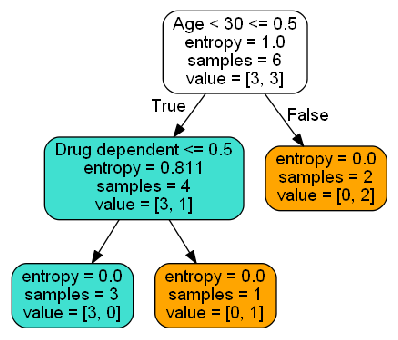

In [34]:
# Visualize data
import collections
!pip install pydotplus
import pydotplus
from sklearn import tree
features = list(X.columns.values)
dot_data = tree.export_graphviz(clf,
                                feature_names=['Good Behavior',  'Age < 30'  ,'Drug dependent'],
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('tree.png')

import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6));
plt.imshow(plt.imread('tree.png'));
plt.axis('off');
plt.show();